In [1]:
import os
import sys
import glob

from functools import partial

import numpy as np
from PIL import Image

import torch
from torchvision.transforms import ToTensor

import numpy as np
import random
import csv

from torchnet.dataset import ListDataset, TransformDataset
from torchnet.transform import compose
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import Sampler

from operator import itemgetter

import protonets
from protonets.data.base import convert_dict, CudaTransform, EpisodicBatchSampler, SequentialBatchSampler

from __future__ import print_function, division

from pycocotools.coco import COCO

import skimage.io
import skimage.transform
import skimage.color
import skimage

from PIL import Image

import json

In [2]:
class CocoDataset(Dataset):
    """Coco dataset."""

    def __init__(self, root_dir, set_name='train2017', transform=None):
        """
        Args:
            root_dir (string): COCO directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.set_name = set_name
        self.transform = transform

        self.coco      = COCO(os.path.join(self.root_dir, 'annotations', 'instances_' + self.set_name + '.json'))
        self.image_ids = self.coco.getImgIds()

        self.load_classes()

    def load_classes(self):
        # load class names (name -> label)
        categories = self.coco.loadCats(self.coco.getCatIds())
        categories.sort(key=lambda x: x['id'])

        self.classes             = {}
        self.coco_labels         = {}
        self.coco_labels_inverse = {}
        for c in categories:
            self.coco_labels[len(self.classes)] = c['id']
            self.coco_labels_inverse[c['id']] = len(self.classes)
            self.classes[c['name']] = len(self.classes)

        # also load the reverse (label -> name)
        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):

        img = self.load_image(idx)
        annot = self.load_annotations(idx)
        sample = {'img': img, 'annot': annot}
        if self.transform:
            sample = self.transform(sample)

        return sample

    def load_image(self, image_index):
        image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
        path       = os.path.join(self.root_dir, 'images', self.set_name, image_info['file_name'])
        img = skimage.io.imread(path)

        if len(img.shape) == 2:
            img = skimage.color.gray2rgb(img)

        return img.astype(np.float32)/255.0

    def load_annotations(self, image_index):
        # get ground truth annotations
        annotations_ids = self.coco.getAnnIds(imgIds=self.image_ids[image_index], iscrowd=False)
        annotations     = np.zeros((0, 5))

        # some images appear to miss annotations (like image with id 257034)
        if len(annotations_ids) == 0:
            return annotations

        # parse annotations
        coco_annotations = self.coco.loadAnns(annotations_ids)
        for idx, a in enumerate(coco_annotations):

            # some annotations have basically no width / height, skip them
            if a['bbox'][2] < 1 or a['bbox'][3] < 1:
                continue

            annotation        = np.zeros((1, 5))
            annotation[0, :4] = a['bbox']
            annotation[0, 4]  = self.coco_label_to_label(a['category_id'])
            annotations       = np.append(annotations, annotation, axis=0)

        # transform from [x, y, w, h] to [x1, y1, x2, y2]
        annotations[:, 2] = annotations[:, 0] + annotations[:, 2]
        annotations[:, 3] = annotations[:, 1] + annotations[:, 3]

        return annotations

    def coco_label_to_label(self, coco_label):
        return self.coco_labels_inverse[coco_label]

    def label_to_coco_label(self, label):
        return self.coco_labels[label]

    def image_aspect_ratio(self, image_index):
        image = self.coco.loadImgs(self.image_ids[image_index])[0]
        return float(image['width']) / float(image['height'])

    def num_classes(self):
        return 80
    

def collater(data):
    # how to assemble the data for the batches: 
    # padding sequential data to max length of a batch

    imgs = [s['img'] for s in data]
    annots = [s['annot'] for s in data]
    scales = [s['scale'] for s in data]
        
    widths = [int(s.shape[0]) for s in imgs]
    heights = [int(s.shape[1]) for s in imgs]
    batch_size = len(imgs)

    max_width = np.array(widths).max()
    max_height = np.array(heights).max()

    padded_imgs = torch.zeros(batch_size, max_width, max_height, 3)

    for i in range(batch_size):
        img = imgs[i]
        padded_imgs[i, :int(img.shape[0]), :int(img.shape[1]), :] = img
        # add zeros to the right and bottom if image is smaller than max size of the batch

    max_num_annots = max(annot.shape[0] for annot in annots)
    
    if max_num_annots > 0:

        annot_padded = torch.ones((len(annots), max_num_annots, 5)) * -1

        if max_num_annots > 0:
            for idx, annot in enumerate(annots):
                #print(annot.shape)
                if annot.shape[0] > 0:
                    annot_padded[idx, :annot.shape[0], :] = annot
                    # add -1 to the right if less annotations than max number of annotations in the batch
    else:
        annot_padded = torch.ones((len(annots), 1, 5)) * -1


    padded_imgs = padded_imgs.permute(0, 3, 1, 2)

    return {'img': padded_imgs, 'annot': annot_padded, 'scale': scales}


class Resizer(object):
    """Convert ndarrays in sample to Tensors."""
    # rescale image

    def __call__(self, sample, min_side=608, max_side=1024):
        image, annots = sample['img'], sample['annot']

        rows, cols, cns = image.shape
        # rows, columns, channels 

        smallest_side = min(rows, cols)

        # rescale the image so the smallest side is min_side
        scale = min_side / smallest_side

        # check if the largest side is now greater than max_side, which can happen
        # when images have a large aspect ratio
        largest_side = max(rows, cols)

        if largest_side * scale > max_side:
            scale = max_side / largest_side

        # resize the image with the computed scale
        image = skimage.transform.resize(image, (int(round(rows*scale)), int(round((cols*scale)))))
        rows, cols, cns = image.shape

        pad_w = 32 - rows%32
        pad_h = 32 - cols%32

        new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
        new_image[:rows, :cols, :] = image.astype(np.float32)

        annots[:, :4] *= scale

        return {'img': torch.from_numpy(new_image), 'annot': torch.from_numpy(annots), 'scale': scale}


class Augmenter(object):
    """Convert ndarrays in sample to Tensors."""
    # flip images horizontally to augment the data

    def __call__(self, sample, flip_x=0.5):

        if np.random.rand() < flip_x:
            image, annots = sample['img'], sample['annot']
            image = image[:, ::-1, :]

            rows, cols, channels = image.shape

            x1 = annots[:, 0].copy()
            x2 = annots[:, 2].copy()
            
            x_tmp = x1.copy()

            annots[:, 0] = cols - x2
            annots[:, 2] = cols - x_tmp

            sample = {'img': image, 'annot': annots}

        return sample


class Normalizer(object):

    def __init__(self):
        # pretrained on ImageNet
        self.mean = np.array([[[0.485, 0.456, 0.406]]])
        self.std = np.array([[[0.229, 0.224, 0.225]]])

    def __call__(self, sample):

        image, annots = sample['img'], sample['annot']

        return {'img':((image.astype(np.float32)-self.mean)/self.std), 'annot': annots}

class UnNormalizer(object):
    def __init__(self, mean=None, std=None):
        if mean == None:
            self.mean = [0.485, 0.456, 0.406]
        else:
            self.mean = mean
        if std == None:
            self.std = [0.229, 0.224, 0.225]
        else:
            self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


In [3]:
coco_path = '/scratch/users/isarao/coco'

dataset_train = CocoDataset(coco_path, set_name='train2017', transform=transforms.Compose([Normalizer(), Resizer()]))
#dataset_val = CocoDataset(coco_path, set_name='val2017', transform=transforms.Compose([Normalizer(), Resizer()]))

loading annotations into memory...
Done (t=17.20s)
creating index...
index created!


In [4]:
map = {}
for key, value in dataset_train.classes.items(): 
    catIds = dataset_train.coco.getCatIds(catNms=[key])
    imgIds = dataset_train.coco.getImgIds(catIds=catIds)
    
    map[key] = imgIds

class_names = list(map.keys())
#print(map)

# map_val = {}
# for key, value in dataset_val.classes.items(): 
#     catIds = dataset_val.coco.getCatIds(catNms=[key])
#     imgIds = dataset_val.coco.getImgIds(catIds=catIds)
    
#     map_val[key] = imgIds

# class_names_val = list(map_val.keys())
#print(map_val)

In [5]:
# with open('map_train.json', 'w') as json_file:
#     json.dump(map, json_file)
    
# with open('map_val.json', 'w') as json_file:
#     json.dump(map_val, json_file)

In [6]:
# with open('map_train.json') as json_file:
#     map_train = json.load(json_file)

# print(map_train)

In [7]:
COCO_DATA_DIR  = os.path.join('/scratch/users/isarao/coco/images')
COCO_CACHE = { }

def load_image_path(key, out_field, d):
    img = Image.open(d[key])
    d[out_field] = img.copy()
    img.close()
    return d
    
def load_class_images(d):
    if d['class'] not in COCO_CACHE:
        image_dir = os.path.join(COCO_DATA_DIR, 'train2017')
        
        class_images = []
        for values in map[d['class']]: 
            class_images.append(values)
            
        class_images = sorted(class_images)
       
        image_ds = TransformDataset(ListDataset(class_images),
                                    compose([partial(convert_dict, 'image_id')]))

        loader = torch.utils.data.DataLoader(image_ds, batch_size=len(image_ds), shuffle=False)

        for sample in loader:
            COCO_CACHE[d['class']] = sample['image_id']
            break # only need one sample because batch size equal to dataset length

    return { 'class': d['class'], 'data': COCO_CACHE[d['class']] }

def extract_episode(n_sample, d):
    # data: N x C x H x W
    n_examples = len(d['data'])

    example_inds = torch.randperm(n_examples)[:n_sample]

    x = itemgetter(*example_inds)(d['data'])

    return {
        'class': d['class'],
        'x': x
    }

def load():

    ret = { }
    n_way = 2 # how to do a random number for the classes
    n_sample = 2
    n_episodes = 2
    
    transforms = [partial(convert_dict, 'class'),
                  load_class_images,
                  partial(extract_episode, n_sample)]
    
    transforms = compose(transforms)

    ds = TransformDataset(ListDataset(class_names), transforms)

    sampler = EpisodicBatchSampler(len(ds), n_way, n_episodes)

    # use num_workers=0, otherwise may receive duplicate episodes
    ret = torch.utils.data.DataLoader(ds, batch_sampler=sampler, num_workers=0)

    return ret


In [8]:
ds = load()

In [9]:
for sample in ds: 
    print(sample)

{'class': ['chair', 'donut'], 'x': [tensor([194247, 147894]), tensor([55363, 19967])]}
{'class': ['handbag', 'sink'], 'x': [tensor([ 69654, 300056]), tensor([501138,  95867])]}


In [10]:
for iter_num, data in enumerate(ds):
    print(data)

{'class': ['stop sign', 'clock'], 'x': [tensor([267184, 142592]), tensor([559484, 122118])]}
{'class': ['bear', 'donut'], 'x': [tensor([490160, 330677]), tensor([398622, 472690])]}


In [11]:
sample = next(iter(ds))

In [12]:
sample

{'class': ['hair drier', 'refrigerator'],
 'x': [tensor([475804, 363022]), tensor([574760, 468518])]}

In [13]:
batch_size = len(sample['class'])

In [14]:
def load_image(image_id):
    image_info = dataset_train.coco.loadImgs(image_id)[0]
    path       = os.path.join(coco_path, 'images', 'train2017', image_info['file_name'])
    img = skimage.io.imread(path)

    if len(img.shape) == 2:
        img = skimage.color.gray2rgb(img)

    return img.astype(np.float32)/255.0

#print(load_image(329711))

In [15]:
categories = dataset_train.coco.loadCats(dataset_train.coco.getCatIds())
categories.sort(key=lambda x: x['id'])
    
coco_labels_inverse = {}
classes = {}
for c in categories:
    coco_labels_inverse[c['id']] = len(classes)
    classes[c['name']] = len(classes)
    
#print(classes)
#print(coco_labels_inverse)

def coco_label_to_label(coco_label):
    return coco_labels_inverse[coco_label]

#print(coco_label_to_label(32))

In [16]:
with open('categories_train.json', 'w') as json_file:
    json.dump(categories, json_file)

In [17]:
def load_annotations(image_id):
    # get ground truth annotations
    annotations_ids = dataset_train.coco.getAnnIds(imgIds=image_id, iscrowd=False)
    annotations     = np.zeros((0, 5))

    # some images appear to miss annotations (like image with id 257034)
    if len(annotations_ids) == 0:
        return annotations

    # parse annotations
    coco_annotations = dataset_train.coco.loadAnns(annotations_ids)
    for idx, a in enumerate(coco_annotations):

        # some annotations have basically no width / height, skip them
        if a['bbox'][2] < 1 or a['bbox'][3] < 1:
            continue

        annotation        = np.zeros((1, 5))
        annotation[0, :4] = a['bbox']
        annotation[0, 4]  = coco_label_to_label(a['category_id'])
        annotations       = np.append(annotations, annotation, axis=0)

    # transform from [x, y, w, h] to [x1, y1, x2, y2]
    annotations[:, 2] = annotations[:, 0] + annotations[:, 2]
    annotations[:, 3] = annotations[:, 1] + annotations[:, 3]

    return annotations

#load_annotations(87264)

In [18]:
# def Resizer(sample,  min_side=608, max_side=1024):
#     """Convert ndarrays in sample to Tensors."""

#     image, annots = sample['img'], sample['annot']

#     rows, cols, cns = image.shape
#     # rows, columns, channels 

#     smallest_side = min(rows, cols)

#     # rescale the image so the smallest side is min_side
#     scale = min_side / smallest_side

#     # check if the largest side is now greater than max_side, which can happen
#     # when images have a large aspect ratio
#     largest_side = max(rows, cols)

#     if largest_side * scale > max_side:
#         scale = max_side / largest_side

#     # resize the image with the computed scale
#     image = skimage.transform.resize(image, (int(round(rows*scale)), int(round((cols*scale)))))
#     rows, cols, cns = image.shape

#     pad_w = 32 - rows%32
#     pad_h = 32 - cols%32

#     new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
#     new_image[:rows, :cols, :] = image.astype(np.float32)

#     annots[:, :4] *= scale

#     return {'img': torch.from_numpy(new_image), 'annot': torch.from_numpy(annots), 'scale': scale}

In [27]:
classes_ids = dataset_train.classes

# with open('classes_ids_train.json', 'w') as json_file:
#     json.dump(classes_ids, json_file)
    
print(classes_ids)
#print(sample['class'])
relevant_ids = [classes_ids[x] for x in sample['class']]
#print(relevant_ids)

x_sample = [] 
#mean = np.array([[[0.485, 0.456, 0.406]]])
#std = np.array([[[0.229, 0.224, 0.225]]])
normalizer = Normalizer()
resizer = Resizer()

for i in range(len(sample['x'])): 
    for j in range(len(sample['x'][0])): 
        idx = sample['x'][i][j].item()
        img = load_image(idx)
        #print(img_temp.shape)
        #img =  ((img_temp.astype(np.float32)-mean)/std)
        annots = load_annotations(idx)
        # only keep annotations for the conisidered classes
        annots = annots[np.isin(annots[:,4], relevant_ids)]
        temp = {'img': img, 'annot': annots}
        x_sample.append(resizer(normalizer(temp)))
        #print(resizer(temp)['img'].shape)

print(x_sample[1])

{'person': 0, 'bicycle': 1, 'car': 2, 'motorcycle': 3, 'airplane': 4, 'bus': 5, 'train': 6, 'truck': 7, 'boat': 8, 'traffic light': 9, 'fire hydrant': 10, 'stop sign': 11, 'parking meter': 12, 'bench': 13, 'bird': 14, 'cat': 15, 'dog': 16, 'horse': 17, 'sheep': 18, 'cow': 19, 'elephant': 20, 'bear': 21, 'zebra': 22, 'giraffe': 23, 'backpack': 24, 'umbrella': 25, 'handbag': 26, 'tie': 27, 'suitcase': 28, 'frisbee': 29, 'skis': 30, 'snowboard': 31, 'sports ball': 32, 'kite': 33, 'baseball bat': 34, 'baseball glove': 35, 'skateboard': 36, 'surfboard': 37, 'tennis racket': 38, 'bottle': 39, 'wine glass': 40, 'cup': 41, 'fork': 42, 'knife': 43, 'spoon': 44, 'bowl': 45, 'banana': 46, 'apple': 47, 'sandwich': 48, 'orange': 49, 'broccoli': 50, 'carrot': 51, 'hot dog': 52, 'pizza': 53, 'donut': 54, 'cake': 55, 'chair': 56, 'couch': 57, 'potted plant': 58, 'bed': 59, 'dining table': 60, 'toilet': 61, 'tv': 62, 'laptop': 63, 'mouse': 64, 'remote': 65, 'keyboard': 66, 'cell phone': 67, 'microwave'

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
def show(img):
    npimg = img
    plt.imshow(img)

(463, 640, 3)

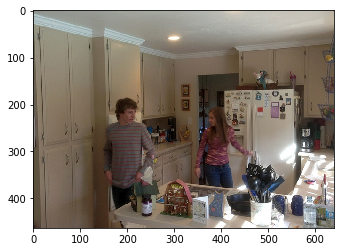

In [21]:
show(img)
img.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([640, 864, 3])


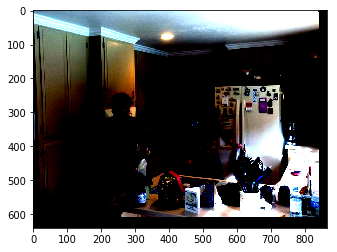

In [22]:
show(resizer(normalizer(temp))['img'])
print(resizer(normalizer(temp))['img'].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([768, 640, 3])
torch.Size([1, 5])
tensor([[164.6599, 103.8948, 264.9508, 247.9547,  78.0000]],
       dtype=torch.float64)
4


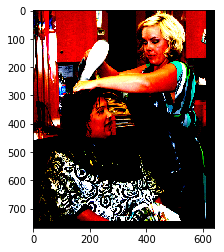

In [36]:
i=2
print(x_sample[i]['img'].size())
print(x_sample[i]['annot'].size())
print(x_sample[i]['annot'])
show(x_sample[i]['img'])
print(len(x_sample))

In [25]:
def collater(data):
    # how to assemble the data for the batches: 
    # padding sequential data to max length of a batch

    imgs = [s['img'] for s in data]
    annots = [s['annot'] for s in data]
    scales = [s['scale'] for s in data]
        
    widths = [int(s.shape[0]) for s in imgs]
    heights = [int(s.shape[1]) for s in imgs]
    batch_size = len(imgs)

    max_width = np.array(widths).max()
    max_height = np.array(heights).max()

    padded_imgs = torch.zeros(batch_size, max_width, max_height, 3)

    for i in range(batch_size):
        img = imgs[i]
        padded_imgs[i, :int(img.shape[0]), :int(img.shape[1]), :] = img
        # add zeros to the right and bottom if image is smaller than max size of the batch

    max_num_annots = max(annot.shape[0] for annot in annots)
    
    if max_num_annots > 0:

        annot_padded = torch.ones((len(annots), max_num_annots, 5)) * -1

        if max_num_annots > 0:
            for idx, annot in enumerate(annots):
                #print(annot.shape)
                if annot.shape[0] > 0:
                    annot_padded[idx, :annot.shape[0], :] = annot
                    # add -1 to the right if less annotations than max number of annotations in the batch
    else:
        annot_padded = torch.ones((len(annots), 1, 5)) * -1


    padded_imgs = padded_imgs.permute(0, 3, 1, 2)

    return {'img': padded_imgs, 'annot': annot_padded, 'scale': scales}

In [26]:
final_data = collater(x_sample)

In [ ]:
#dataset_train = CocoDataset(parser.coco_path, set_name='train2017', transform=transforms.Compose([Normalizer(), Resizer()]))
    
#sampler = AspectRatioBasedSampler(dataset_train, batch_size=2, drop_last=False)
#dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler)


In [32]:
x_sample[1]['img'].shape[2]

3

In [1]:
torch.zeros(1,1)

NameError: name 'torch' is not defined

In [2]:
import numpy as np

In [4]:
test = np.ones(4)

In [5]:
test[:4]

array([1., 1., 1., 1.])

In [6]:
test

array([1., 1., 1., 1.])